In [4]:
!pip install xgboost

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import functions.uap as uap
import pickle as pk

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

***
# Data Import, Feature Selection and Target Transformation

Feature selections is performed according to findings during EDA.

Transformation of target PM2.5 values into binary labels (healthy / unhealthy) is also performed using a script from the EDA phase.

In [6]:
df = uap.get_data()
df = uap.select_and_rename_columns(df, 'target_health') # GFS data needs to be added in the function
df

,target,temperature,specific_humidity,NO2_conc,O3_conc,CO_conc,FA_conc,cloud_coverage,cloud_density,AAI,SO2_conc,windspeed
0,Healthy,18.516840,0.00804,0.000074,0.119095,0.021080,0.000064,0.000000,NaN,-1.231330,-0.000127,2.343506
1,Healthy,22.546533,0.00839,0.000076,0.115179,0.022017,0.000171,0.059358,5.958538,-1.082553,0.000150,3.536009
2,Healthy,27.031030,0.00750,0.000067,0.115876,0.020677,0.000124,0.082247,5.755760,-1.001241,0.000150,6.157557
3,Healthy,23.971857,0.00391,0.000083,0.141557,0.021207,0.000081,0.121555,6.246885,-0.777023,0.000227,3.198883
4,Healthy,16.816309,0.00535,0.000070,0.126369,0.037766,0.000140,0.037008,4.205691,0.366324,0.000390,3.742413
...,...,...,...,...,...,...,...,...,...,...,...,...
30552,Healthy,4.256799,0.00352,0.000063,0.174995,0.039941,0.000024,0.001238,5.875377,-1.412609,0.000312,6.383007
30553,Healthy,2.067438,0.00341,0.000072,0.157659,0.037872,-0.000014,0.007750,5.068010,-1.448509,0.000362,2.463107
30554,Healthy,4.438623,0.00356,0.000068,0.168295,0.038539,0.000094,0.026480,10.443789,-1.722478,0.000107,0.171193
30555,Unhealthy,10.573236,0.00523,0.000086,0.160637,0.038757,0.000063,0.175418,9.744343,-2.042785,0.000014,1.504039


In [7]:
df['target'].value_counts(), df['target'].value_counts(normalize=True)

(target
 Healthy      25618
 Unhealthy     4939
 Name: count, dtype: int64,
 target
 Healthy      0.838368
 Unhealthy    0.161632
 Name: proportion, dtype: float64)

In [8]:
df.dtypes

target               category
temperature           float64
specific_humidity     float64
NO2_conc              float64
O3_conc               float64
CO_conc               float64
FA_conc               float64
cloud_coverage        float64
cloud_density         float64
AAI                   float64
SO2_conc              float64
windspeed             float64
dtype: object

In [9]:
df.isna().sum(), len(df)

(target                  0
 temperature             0
 specific_humidity       0
 NO2_conc             2189
 O3_conc               283
 CO_conc              5423
 FA_conc              7425
 cloud_coverage        374
 cloud_density        1522
 AAI                   197
 SO2_conc             7237
 windspeed               0
 dtype: int64,
 30557)

<Axes: >

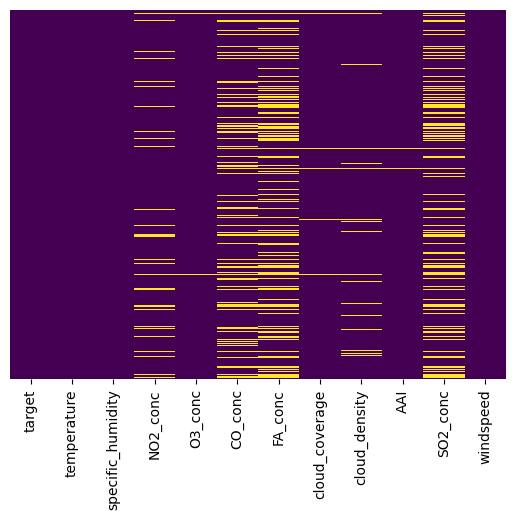

In [10]:
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)

In [11]:
nan_drop_stats = {}
total_rows = len(df)

for threshold in range(2, 7): 
    count = (df.isna().sum(axis=1) >= threshold).sum()
    percentage = (count / total_rows) * 100
    nan_drop_stats[threshold] = (count, percentage)

for a, (count, pct) in nan_drop_stats.items():
    print(f"Rows with at least {a} NaNs: {count} ({pct:.2f}%)")


Rows with at least 2 NaNs: 7243 (23.70%)
Rows with at least 3 NaNs: 4061 (13.29%)
Rows with at least 4 NaNs: 1979 (6.48%)
Rows with at least 5 NaNs: 379 (1.24%)
Rows with at least 6 NaNs: 328 (1.07%)


In [12]:
df_nan = df.copy()
df_nan = df_nan[df_nan.isna().sum(axis=1) < 5]
len(df_nan)

30178

<Axes: >

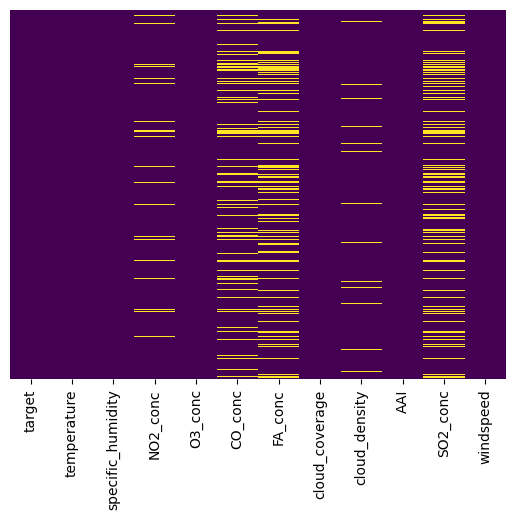

In [13]:
sns.heatmap(df_nan.isna(), cbar=False, cmap='viridis', yticklabels=False)

***
# Modelling

In [52]:
X = df_nan.drop(columns=['target'])

le = LabelEncoder()
y = df_nan['target']
y = le.fit_transform(y)

In [53]:
print(y)

[0 0 0 ... 0 0 1]


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24142, 11), (6036, 11), (24142,), (6036,))

In [ ]:
pipe = ImbPipeline([
    ('imputer' , KNNImputer()),
    ('scaler' , MinMaxScaler()),
    ('oversampling', SMOTE()),     # synthetic oversampling
    ('select', SelectKBest()),
    ('model', LogisticRegression())
])

In [74]:
print(np.linspace(0.01, 10, 5))

[ 0.01    2.5075  5.005   7.5025 10.    ]


In [77]:
param_grid = [
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [LogisticRegression(solver='saga')],
        'model__penalty' : ['l1', 'l2', 'elasticnet'],
        'model__C' : np.logspace(-2, 2, 5),
        'model__class_weight' : ['balanced', None]
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [KNeighborsClassifier()],
        'model__n_neighbors' : np.arange(1, 14, 2),
        'model__weights' : ['uniform', 'distance'],
        'model__p' : [1, 2, 3, 4]
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [RandomForestClassifier()],
        'model__n_estimators' : [5, 10, 50, 100, 1000],
        'model__criterion' : ['gini', 'entropy', 'log_loss'],
        'model__max_depth' : [None] + list(np.logspace(1, 6, num=7, base=2).astype(int)),
        'model__min_samples_split' : list(np.logspace(1, 6, num=7, base=2).astype(int)),
        'model__min_samples_leaf' : list(np.logspace(1, 6, num=7, base=2).astype(int)),
        'model__min_weight_fraction_leaf' : np.linspace(0.0, 0.05, 5).tolist(),
        'model__max_leaf_nodes' : [None] + list(np.linspace(5, 100, 5).astype(int)),
        'model__ccp_alpha' : np.linspace(0.01, 10, 5)
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [GradientBoostingClassifier()],
        'model__loss' : ['log_loss', 'exponential'],
        'model__learning_rate' : np.linspace(0.001, 0.3, 5).tolist(),
        'model__n_estimators' : [5, 10, 50, 100, 1000],
        'model__subsample' : np.linspace(0.1, 1.0, 5).tolist(),
        'model__criterion' : ['friedman_mse', 'squared_error'],
        'model__min_samples_split' : list(np.logspace(1, 6, num=7, base=2).astype(int)),
        'model__min_samples_leaf' : list(np.logspace(1, 6, num=7, base=2).astype(int)),
        'model__min_weight_fraction_leaf' : np.linspace(0.0, 0.05, 5).tolist(),
        'model__max_depth' : np.linspace(2, 10, 5).astype(int).tolist(),
        'model__ccp_alpha' : np.linspace(0.01, 10, 5)
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [XGBClassifier(verbosity=2)],
        'model__booster' : ['gbtree', 'gblinear', 'dart'],
        'model__eta' : [0.01, 0.25, 0.5, 0.75, 1],
        'model__lambda' : [0, 1, 2, 5, 10],
        'model__alpha' : [0, 1, 2, 5, 10]
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [SVC()],
        'model__C' : [np.logspace(-3, 3, 7).tolist()],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : np.linspace(2, 11, 5).astype(int).tolist(),
        'model__coef0' : np.linspace(0, 10, 5).tolist()
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [SGDClassifier()],
        'model__loss' : ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'model__alpha' : [np.logspace(-6, -2, num=5)]
    },
]

In [ ]:
param_grid_test = [
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [LogisticRegression(solver='saga')],
        'model__penalty' : ['l1', 'l2', 'elasticnet'],
        'model__C' : np.logspace(-2, 2, 5),
        'model__class_weight' : ['balanced', None]
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [KNeighborsClassifier()],
        'model__n_neighbors' : np.arange(1, 14, 2),
        'model__weights' : ['uniform', 'distance'],
        'model__p' : [1, 2, 3, 4]
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [XGBClassifier(verbosity=1)],
        'model__booster' : ['gbtree', 'gblinear', 'dart'],
        'model__eta' : [0.01, 0.25, 0.5, 0.75, 1],
        'model__lambda' : [0, 1, 2, 5, 10],
        'model__alpha' : [0, 1, 2, 5, 10]
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [SVC()],
        'model__C' : np.logspace(-3, 3, 7).tolist(),
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : np.linspace(2, 11, 5).astype(int).tolist(),
        'model__coef0' : np.linspace(0, 10, 5).tolist()
    },
    {
        'select__k': list(np.arange(3, 12, 2)),
        'model' : [SGDClassifier()],
        'model__loss' : ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'model__alpha' : [np.logspace(-6, -2, num=5)]
    },
]

In [ ]:
rnd_grid_search = RandomizedSearchCV(pipe, param_grid_test, cv=2, scoring='f1', n_jobs=-1, verbose=3, n_iter=100)
rnd_grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[CV 1/2] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), model__alpha=1, model__booster=gblinear, model__eta=0.5, model__lambda=10, select__k=5;, score=0.000 total time=  18.8s
[CV 2/2] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsa

ValueError: l1_ratio must be specified when penalty is elasticnet.

***
# Model Evaluation

In [ ]:
# has to be update with the binary logreg model
with open('models/base_linreg_model.pkl', 'rb') as f:
    base_model = pk.load(f)

base_model

LinearRegression()

In [ ]:
uap.check_classification(model, X_train, X_test, y_train, y_test)